In [1]:
from copy import copy
import pickle
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib as mpl
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle

In [306]:
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*1.2

In [308]:
df = pd.read_csv('all.csv', header=0, index_col=0)[['VCL','RHOB', 'PHIE', 'DT', 'GR', 'NPHI', 'PERM_CORE']].dropna(how='any')
display(df.describe())
display(df.corr()[['PERM_CORE']])

,VCL,RHOB,PHIE,DT,GR,NPHI,PERM_CORE
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.242188,2.408765,0.125387,73.531085,75.417738,0.191242,34.491359
std,0.163313,0.052095,0.031777,8.099880,18.952711,0.041768,62.967962
min,0.030400,2.190000,0.027700,59.554900,43.992000,0.115300,0.090000
25%,0.127450,2.380000,0.101800,67.678600,60.637500,0.164150,1.040000
50%,0.193400,2.410000,0.130500,71.832200,76.635000,0.200600,3.720000
75%,0.297800,2.440000,0.147150,80.797900,89.914500,0.216750,40.765000
max,0.813200,2.516700,0.184500,106.765300,140.400000,0.378800,378.750000


,PERM_CORE
VCL,-0.349052
RHOB,0.097330
PHIE,0.463302
DT,0.446248
GR,-0.567002
NPHI,0.271309
PERM_CORE,1.000000


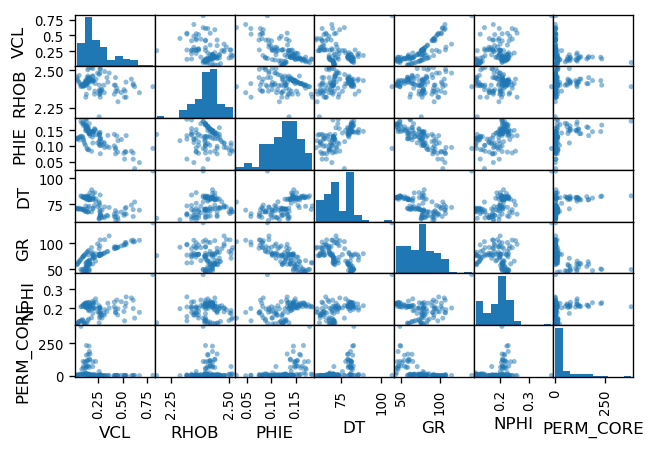

In [309]:
scatter_matrix(df)
plt.show()

In [310]:
def plot_learning_curve(estimator, x, y, bins=20):
    err_train = []
    err_val = []
    x, y, x_val, y_val = train_test_split(x, y, test_size=0.1)
    batch = list(map(int, np.linspace(0, x.shape[0], num=bins)))
    print(batch)
    for i in range(1, len(batch)):
        estimator.fit(x[0:batch[i]], y[0:batch[i]])
        p = estimator.predict(x[0:batch[i]])
        err_train.append(mean_squared_error(y[0:batch[i]], p))
        p = estimator.predict(x_val)
        err_train.append(mean_squared_error(y_val, p))
    plt.plot(err_train, label='Training error')
    plt.plot(err_val, label='Validation error')
    plt.title('Learning curve')
    plt.legend()
    plt.xlabel('Sample')
    plt.ylabel('Error')
    plt.show()

## Ý tưởng 1:

Do 6 thuộc tính trước đây (DT, GR, NHPI, GHOB, VCL, PHIE) dùng để dự đoán PERM_CORE không tốt. Độ tương quan với PERM_CORE thấp

Dùng 5 thuộc tính: VCL, RHOB, PHIE, SW, RES_DEEP tạo ra FZI_CORE (sử dụng neural network hoặc xgboot)

Dùng FZI_CORE tạo ra PERM_CORE, có thể sử dụng các mô hình đơn giản như linear regression có áp dụng Polynormial

Ưu điểm: không phụ thuộc vào FZI_CORE (model 1 tạo FZI_CORE từ 5 curve còn lại)

Nhược điểm: model 1 có độ chính xác không cao (~ 65%)

## Load data

In [2]:
df = pd.read_csv('all.csv', header=0, index_col=0)[['VCL','RHOB', 'PHIE', 'SW', 'RES_DEEP', 'FZI_CORE', 'PERM_CORE']]

## Visualization data and correlative table

In [3]:
df = df.dropna(how='any', axis=0)

### Describe table

In [313]:
df.describe()

,VCL,RHOB,PHIE,SW,RES_DEEP,FZI_CORE,PERM_CORE
count,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000
mean,0.447146,2.512348,0.056560,0.753843,88.061100,1.329994,44.649122
std,0.355542,0.108788,0.054786,0.309639,201.827052,1.821108,110.949529
min,-0.072900,2.222200,0.000000,0.073100,1.858800,0.061200,0.000300
25%,0.118100,2.432000,0.000200,0.453800,5.560900,0.414200,0.058300
50%,0.364000,2.529900,0.044200,1.000000,15.092500,0.587100,0.400600
75%,0.795400,2.609300,0.103200,1.000000,61.691500,0.920500,0.560600
max,1.000000,2.699000,0.199200,1.000000,2588.878400,10.228300,986.232200


### Correlative table

In [314]:
df.corr()

,VCL,RHOB,PHIE,SW,RES_DEEP,FZI_CORE,PERM_CORE
VCL,1.000000,0.598186,-0.870933,0.728969,-0.448261,-0.396252,-0.358576
RHOB,0.598186,1.000000,-0.797946,0.741497,-0.524614,-0.511285,-0.474231
PHIE,-0.870933,-0.797946,1.000000,-0.863891,0.519079,0.508842,0.473217
SW,0.728969,0.741497,-0.863891,1.000000,-0.659273,-0.527687,-0.475991
RES_DEEP,-0.448261,-0.524614,0.519079,-0.659273,1.000000,0.498157,0.449115
FZI_CORE,-0.396252,-0.511285,0.508842,-0.527687,0.498157,1.000000,0.939953
PERM_CORE,-0.358576,-0.474231,0.473217,-0.475991,0.449115,0.939953,1.000000


## Bi-variate plot

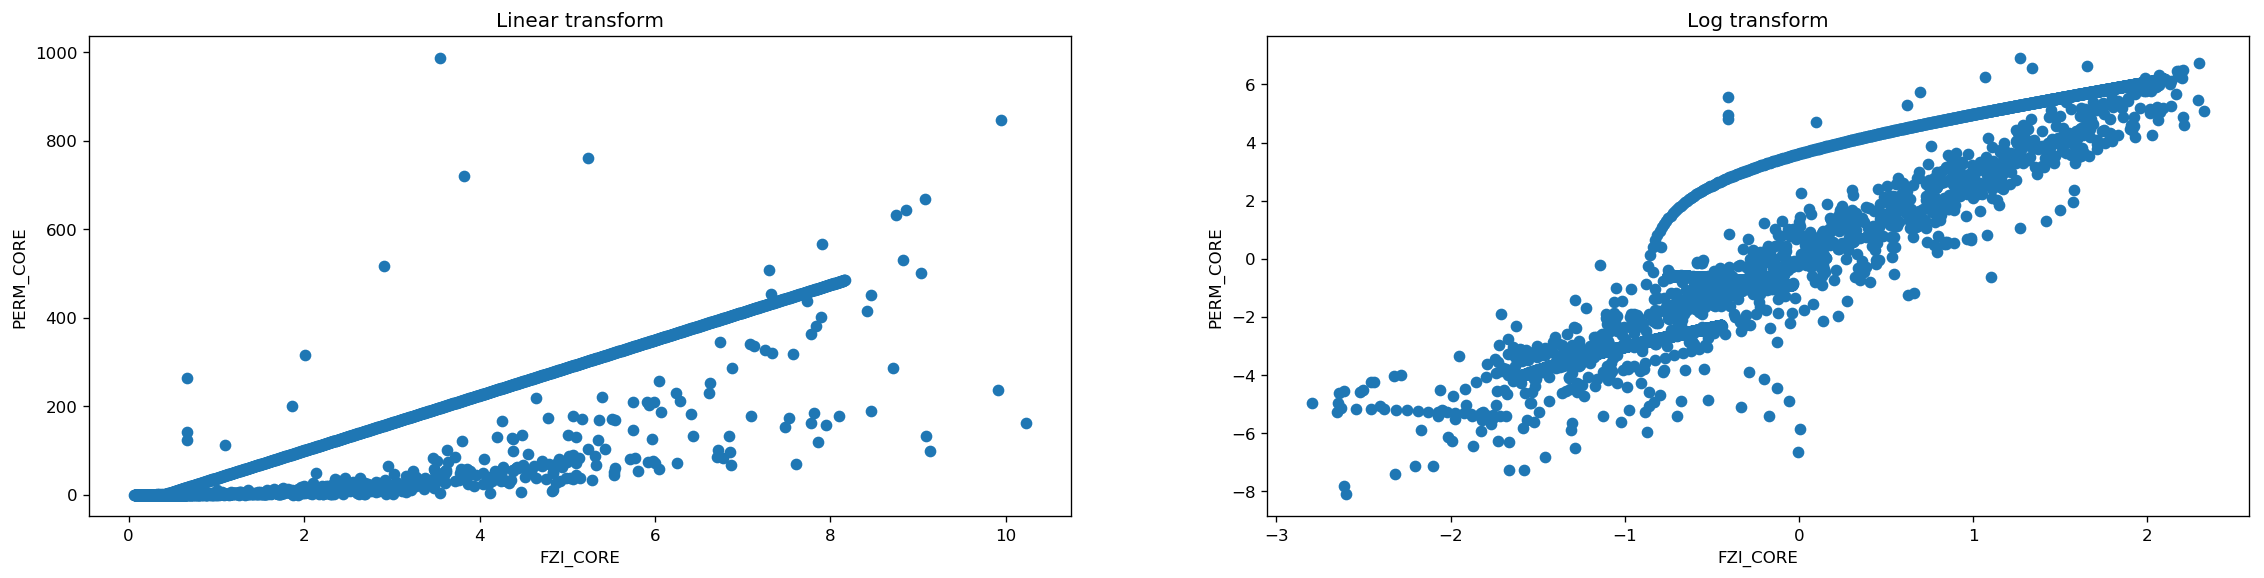

In [315]:
plt.subplots_adjust(left=2, right=5, top=5, bottom=4)
plt.subplot(1, 2, 1)
plt.title('Linear transform')
plt.xlabel('FZI_CORE'); plt.ylabel('PERM_CORE')
plt.scatter(df['FZI_CORE'], df['PERM_CORE'])
plt.subplot(1, 2, 2)
plt.title('Log transform')
plt.xlabel('FZI_CORE'); plt.ylabel('PERM_CORE')
plt.scatter(np.log(df['FZI_CORE']), np.log(df['PERM_CORE']))
plt.show()

## Split train and test set

In [4]:
df = shuffle(df)
testset, trainset = df.values[:1000, :], df.values[1000:, :]

## Setting Stacking model

In [45]:
class Stacking(object):
    def __init__(self, base=[LinearRegression(), SGDRegressor(max_iter=1000, alpha=1), SVR(C=20)], 
                 blender=MLPRegressor(solver='adam', max_iter=1000)):
        self.base = base
        self.blender = blender
    
    def fit(self, x_train, y_train):
        x_base, x_blender, y_base, y_blender = train_test_split(x_train, y_train, test_size=0.4)
        for base in self.base:
            base.fit(x_base, y_base)
        prediction = []
        for base in self.base:
            p = base.predict(x_blender)
            prediction.append(p)
        prediction = np.array(prediction).T
        
        self.blender.fit(prediction, y_blender)
    
    def predict(self, x):
        prediction = []
        for base in self.base:
            p = base.predict(x)
            prediction.append(p)
        prediction = np.array(prediction).T
        blender_result = self.blender.predict(prediction)
        return blender_result
        
    def score(self, x_test, y_test):
        blender_result = self.predict(x_test)
        r2 = r2_score(y_test, blender_result)
        return r2

## Train model FZI

In [318]:
fzi_steps = [
    ('standard', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('estimator', MLPRegressor())
]
fzi_model = Pipeline(fzi_steps)

In [321]:
fzi_params = {
    'poly__degree': [2],
    'estimator__max_iter': [1000],
    'estimator__hidden_layer_sizes': [(100,)],
    'estimator__alpha': [4, 4.1, 4.2, 4.3, 4.4],
    'estimator__solver': ['lbfgs'],
    'estimator__validation_fraction': [0.15],
    'estimator__learning_rate': ['adaptive'],
    'estimator__learning_rate_init': [0.01]
}
fzi_search = GridSearchCV(fzi_model, fzi_params, cv=4, return_train_score=True)
fzi_search.fit(trainset[:,:-2], trainset[:, -2])

GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standard', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('estimator', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsi...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'poly__degree': [2], 'estimator__max_iter': [1000], 'estimator__hidden_layer_sizes': [(100,)], 'estimator__alpha': [4, 4.1, 4.2, 4.3, 4.4], 'estimator__solver': ['lbfgs'], 'estimator__validation_fraction': [0.15], 'estimator__learning_rate': ['adaptive'], 'estimator__learning_rate_init': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [322]:
pd.DataFrame(fzi_search.cv_results_).sort_values(by='mean_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_estimator__alpha,param_estimator__hidden_layer_sizes,param_estimator__learning_rate,param_estimator__learning_rate_init,param_estimator__max_iter,param_estimator__solver,...,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,7.357844,0.002152,0.639906,0.715730,4.1,"(100,)",adaptive,0.01,1000,lbfgs,...,0.641179,0.719054,0.655181,0.707654,0.634133,0.716394,0.120139,0.000022,0.009801,0.004833
0,7.503727,0.002177,0.640619,0.716759,4,"(100,)",adaptive,0.01,1000,lbfgs,...,0.634218,0.716716,0.662449,0.714845,0.634091,0.714695,0.020787,0.000023,0.012641,0.002455
4,8.300694,0.002298,0.641128,0.717617,4.4,"(100,)",adaptive,0.01,1000,lbfgs,...,0.647789,0.713330,0.653322,0.711880,0.631682,0.721214,0.379238,0.000143,0.009626,0.005137
3,8.159850,0.002401,0.643134,0.713118,4.3,"(100,)",adaptive,0.01,1000,lbfgs,...,0.650799,0.713123,0.654177,0.710419,0.629061,0.707819,0.713556,0.000395,0.010002,0.004981
2,7.423586,0.002173,0.645734,0.718620,4.2,"(100,)",adaptive,0.01,1000,lbfgs,...,0.651583,0.720389,0.647612,0.707439,0.644894,0.719933,0.056281,0.000020,0.004633,0.006991


In [325]:
print('Score: %.3f' % fzi_search.best_estimator_.score(testset[:,:-2], testset[:, -2]))

Score: 0.678


In [326]:
perm_steps = [
    ('standard', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('estimator', LinearRegression())
]
perm_model = Pipeline(perm_steps)

In [327]:
perm_params = {
    'poly__degree': [2, 3]
}
perm_search = GridSearchCV(perm_model, perm_params, return_train_score=True)
perm_search.fit(trainset[:,-2:-1], trainset[:,-1])
pd.DataFrame(perm_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_poly__degree,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.002009,0.000765,0.892584,0.893739,2,{'poly__degree': 2},2,0.885490,0.897472,0.899263,0.890499,0.893003,0.893247,0.000028,0.000036,0.005631,0.002868
1,0.001978,0.000845,0.898656,0.900303,3,{'poly__degree': 3},1,0.887428,0.906176,0.905201,0.897246,0.903345,0.897486,0.000074,0.000018,0.007978,0.004154


In [328]:
print('Score: %.3f' % perm_search.best_estimator_.score(testset[:,-2:-1], testset[:, -1]))

Score: 0.889


In [330]:
p = fzi_search.best_estimator_.predict(testset[:, :-2])
p2 = perm_search.best_estimator_.predict(p.reshape(-1,1))
print('Mean absolute error: %.3f' % mean_absolute_error(p2, testset[:,-1]))

Mean absolute error: 31.598


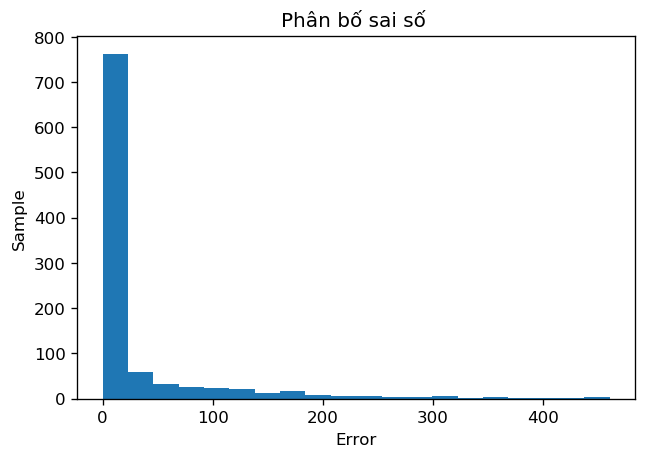

In [333]:
plt.hist(np.abs(p2-testset[:,-1]), bins=20)
plt.title('Phân bố sai số ')
plt.xlabel('Error')
plt.ylabel('Sample')
plt.show()

## Ý tưởng 2:

Dùng 6 thuộc tính tạo ra PERM_CORE

Ưu điểm: Dễ dàng xây dựng model, độ chính xác cao (> 90%)

Nhược điểm: FZI_CORE có thể khó đo được trên thực địa giống như PERM_CORE

In [69]:
st = Stacking()
std = StandardScaler()
std.fit(trainset[:,:-1])
st.fit(std.transform(trainset[:,:-1]), trainset[:,-1])
print('Score: %.3f' % st.score(std.transform(testset[:,:-1]), testset[:,-1]))
p = st.predict(std.transform(testset[:,:-1]))
print('Mean absolute error: %.3f' % mean_absolute_error(testset[:,-1], p))

Score: 0.922
Mean absolute error: 9.268


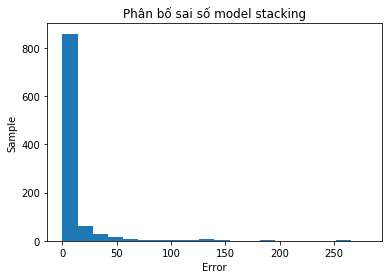

In [70]:
plt.title('Phân bố sai số model stacking')
plt.xlabel('Error')
plt.ylabel('Sample')
plt.hist(np.abs(p-testset[:,-1]), bins=20)
plt.show()